In [6]:
import numpy as np 
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import warnings         
warnings.filterwarnings("ignore")

In [7]:
dfe = pd.read_csv("dataset/resampled-train.csv")

In [8]:

X_resampled = dfe[['ODO', 'Year', 'Age', 'Mileage', 'Engine', 'Power', 'Seats', 'Fuel_Diesel', 'Fuel_Petrol', 'Transmission_Automatic', 'Transmission_Manual', 'Owner_First', 'Owner_Fourth & Above', 'Owner_Second', 'Owner_Third']]

y_resampled = dfe['Price_Category']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Epoch 1/10
431/431 [==============================] - 3s 4ms/step - loss: 0.2719 - accuracy: 0.9018 - val_loss: 0.1269 - val_accuracy: 0.9515
Epoch 2/10
431/431 [==============================] - 2s 4ms/step - loss: 0.1178 - accuracy: 0.9602 - val_loss: 0.0848 - val_accuracy: 0.9718
Epoch 3/10
431/431 [==============================] - 2s 4ms/step - loss: 0.0955 - accuracy: 0.9663 - val_loss: 0.0689 - val_accuracy: 0.9785
Epoch 4/10
431/431 [==============================] - 2s 4ms/step - loss: 0.0858 - accuracy: 0.9709 - val_loss: 0.0992 - val_accuracy: 0.9663
Epoch 5/10
431/431 [==============================] - 2s 4ms/step - loss: 0.0676 - accuracy: 0.9783 - val_loss: 0.0939 - val_accuracy: 0.9672
Epoch 6/10
431/431 [==============================] - 2s 4ms/step - loss: 0.0740 - accuracy: 0.9746 - val_loss: 0.0940 - val_accuracy: 0.9675
Epoch 7/10
431/431 [==============================] - 2s 4ms/step - loss: 0.0618 - accuracy: 0.9785 - val_loss: 0.0574 - val_accuracy: 0.9814
Epoch 

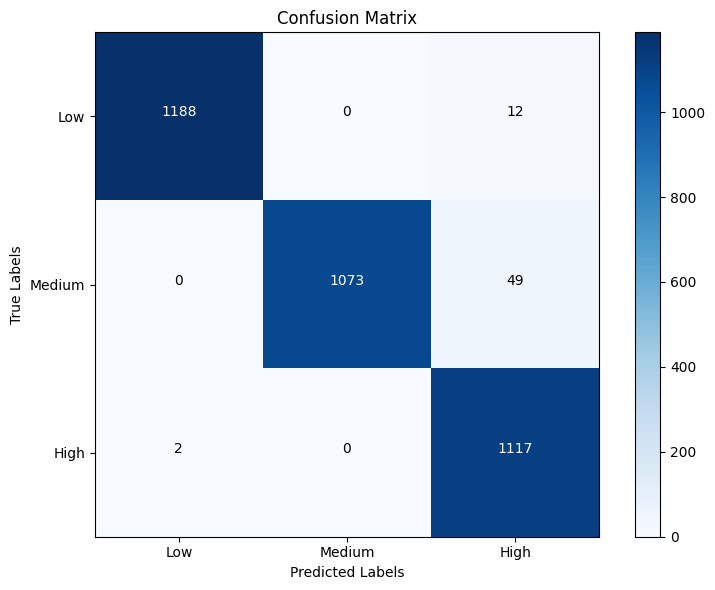

In [10]:
kmeans = KMeans(n_clusters=64, random_state=42)
kmeans.fit(X_train_scaled)
X_train_clustered = kmeans.transform(X_train_scaled)
X_test_clustered = kmeans.transform(X_test_scaled)

total_cluster_size = X_train_clustered.shape[1]

sqrt_cluster_size = int(np.sqrt(total_cluster_size))
grid_shape = (sqrt_cluster_size, sqrt_cluster_size)

num_train_samples = X_train_clustered.shape[0]
num_test_samples = X_test_clustered.shape[0]

X_train_clustered_grid = X_train_clustered.reshape(num_train_samples, *grid_shape)
X_test_clustered_grid = X_test_clustered.reshape(num_test_samples, *grid_shape)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(*grid_shape, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes (Low, Medium, High)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_clustered_grid[..., np.newaxis], to_categorical(y_train), epochs=10, batch_size=32, validation_data=(X_test_clustered_grid[..., np.newaxis], to_categorical(y_test)))

score = model.evaluate(X_test_clustered_grid[..., np.newaxis], to_categorical(y_test), verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_pred = np.argmax(model.predict(X_test_clustered_grid[..., np.newaxis]), axis=-1)

print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Low', 'Medium', 'High']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_mat[i][j]), horizontalalignment='center', color='white' if conf_mat[i][j] > conf_mat.max() / 2 else 'black')

plt.show()
